## Importing the basic libraries

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

## Reading the dataset

In [2]:
funds = pd.read_excel('D:/WORK/UNIVERSITY PROJECTS/OPTIMIZING INVESTMENT PORTFOLIOS SUBJECT TO RISK MANAGEMENT AND STRATEGIC PLANNING/Code/Mutual_Funds.xlsx')

funds.head()

,Date,Price
0,19-05-2023,150.5563
1,18-05-2023,150.6355
2,17-05-2023,150.6505
3,16-05-2023,150.5732
4,15-05-2023,151.1998


## Basic preprocessing sections

### Changing the index to "Date"

In [3]:
# Convert the 'date' column to a datetime format

funds['Date'] = pd.to_datetime(funds['Date'])

# Set the 'date' column as the index

funds.set_index('Date', inplace=True)

### Calculating the Returns according to the price of the Funds closed everyday.

### In the context of the Percentage Change (pct_change()) function, the current value represents the value at index 'i', and the previous value represents the value at index 'i-1'. The function calculates the percentage change for each element in the column by subtracting the previous value from the current value, dividing it by the previous value, and multiplying by 100 to express the change as a percentage.

In [4]:
# Calculate daily returns

returns = funds['Price'].pct_change().dropna()

## 1) Perform GARCH modeling

### GARCH Modeling: Generalized Autoregressive Conditional Heteroskedasticity (GARCH) models allow for the modeling of time-varying volatility. By fitting GARCH models to mutual funds data, you can identify risk factors related to the persistence and clustering of volatility.

In [5]:
import arch

# Perform GARCH(1, 1) modeling

model = arch.arch_model(returns, vol='Garch', p=1, q=1)

results = model.fit()

# Print the model summary

print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 273061373572.7662
Iteration:      2,   Func. Count:     19,   Neg. LLF: 49610893.24190412
Iteration:      3,   Func. Count:     32,   Neg. LLF: 4098857780378964.0
Iteration:      4,   Func. Count:     47,   Neg. LLF: 1.2100000752354228e+19
Iteration:      5,   Func. Count:     61,   Neg. LLF: -4140.432150758715
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4140.432144889639
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 5
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4140.43
Distribution:                  Normal   AIC:                          -8272.86
Method:            Maximum Lik

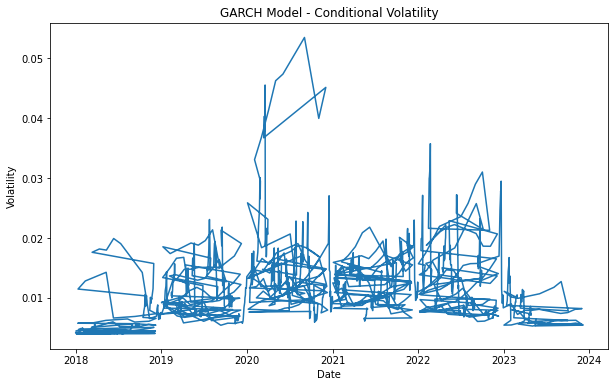

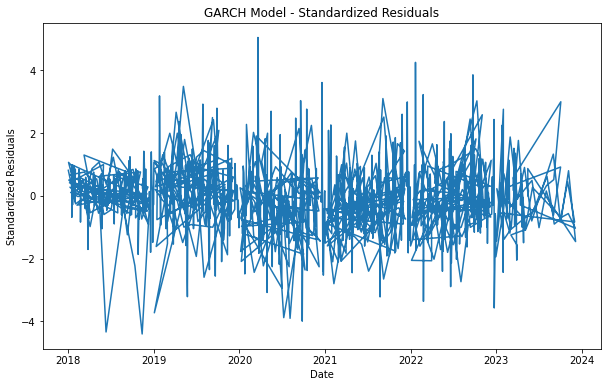

In [7]:
# Plot the volatility

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(results.conditional_volatility)

ax.set_xlabel('Date')

ax.set_ylabel('Volatility')

ax.set_title('GARCH Model - Conditional Volatility')

# Plot the standardized residuals

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(results.resid / results.conditional_volatility)

ax.set_xlabel('Date')

ax.set_ylabel('Standardized Residuals')

ax.set_title('GARCH Model - Standardized Residuals')

plt.show()

## Interpretation :

### i) Volatility Risk: 

#### The GARCH model estimates the conditional volatility of the mutual fund returns. The coefficients in the volatility model section of the summary provide insights into the persistence and impact of past volatility on current volatility. In this case, the coefficient estimates are as follows: omega (3.3630e-06), alpha[1] (0.2000), and beta[1] (0.7800). These coefficients indicate the significance and influence of lagged squared residuals (alpha) and lagged conditional variance (beta) on the current volatility. Higher values of alpha and beta suggest that volatility shocks have a more significant impact on the current volatility of the mutual fund.

### ii) Downside Risk: 
#### While the coefficient estimates provide information about overall volatility, additional analysis can be performed to assess downside risk factors. For example, calculating Value at Risk (VaR) or Expected Shortfall (ES) based on the GARCH model can help quantify the potential losses during extreme market conditions and identify risk factors associated with downside movements.

### iii) Significance of Mean Model Coefficient:
#### The coefficient estimate for the mean model (mu) provides information about the average returns of the mutual fund. In this case, the coefficient estimate is -4.6449e-04. The significance of this coefficient, as indicated by the t-statistic, suggests the presence of a mean effect in the returns of the mutual fund.

### iv) Model Fit and Goodness-of-Fit:
#### The log-likelihood, AIC, and BIC values in the summary provide an assessment of the model fit. A higher log-likelihood and lower AIC and BIC values indicate a better fit. In this case, the log-likelihood is 4140.43, and the AIC and BIC values are -8272.86 and -8252.11, respectively. These values can be used to compare the current GARCH model with alternative models or benchmarks and evaluate the overall adequacy of the model fit.

## 2) Conditional Volatility

### Conditional volatility refers to the phenomenon where periods of high volatility tend to be followed by periods of high volatility, and periods of low volatility tend to be followed by periods of low volatility. By observing the plot of conditional volatility, you can visually identify the clusters of high and low volatility in the mutual funds data. This information can help you understand and analyze the risk factors associated with market turbulence or changes in investor sentiment.

<AxesSubplot: title={'center': 'Volatility Clustering'}, xlabel='Date'>

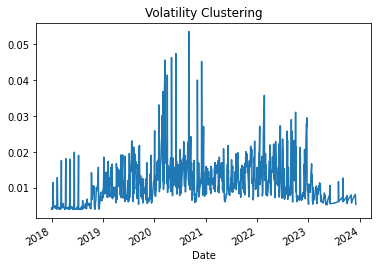

In [8]:
# Extract the conditional volatility

cond_volatility = results.conditional_volatility

# Plot the conditional volatility

cond_volatility.plot(title='Volatility Clustering')

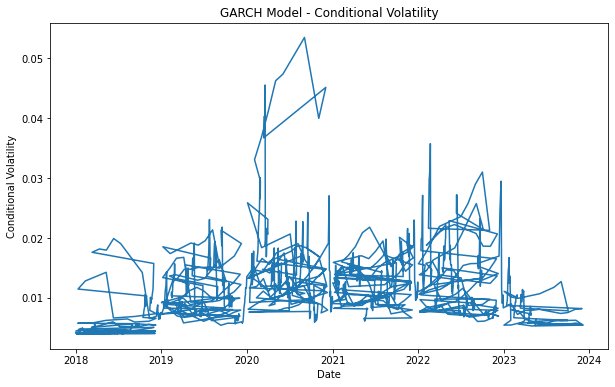

In [9]:
# Plot the conditional volatility

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(results.conditional_volatility)

ax.set_xlabel('Date')

ax.set_ylabel('Conditional Volatility')

ax.set_title('GARCH Model - Conditional Volatility')

plt.show()

## Interpretation :

### The data often exhibits periods of high volatility followed by periods of low volatility. By examining volatility clustering, we identified risk factors related to market turbulence or changes in investor sentiment.

## 3) Regime Switching Models

### Regime switching models capture shifts in the underlying market regime, where the dynamics of returns and risk factors change. By employing these models, you can identify risk factors associated with different market states or regimes.

In [10]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Fit a regime-switching model

markov_model = MarkovRegression(returns, k_regimes=2)

markov_results = markov_model.fit()

# Get the predicted regimes

regime_labels = markov_results.fittedvalues.round()

# Add the regime labels as a new column in the data

funds['regime'] = regime_labels

# Analyze risk factors for each regime

for regime in funds['regime'].unique():

    regime_data = funds[funds['regime'] == regime]
    
    regime_returns = regime_data['Price'].pct_change().dropna()
    
    # Perform further analysis on regime-specific returns
    
    # Example: Calculate regime-specific mean and volatility
    
    regime_mean = regime_returns.mean()
    
    regime_volatility = regime_returns.std()
    
    print(f"Regime {regime}: Mean = {regime_mean}, Volatility = {regime_volatility}")

C:\Users\souna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\souna\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Regime nan: Mean = nan, Volatility = nan
Regime -0.0: Mean = -0.0007323510490698894, Volatility = 0.012977107984401581


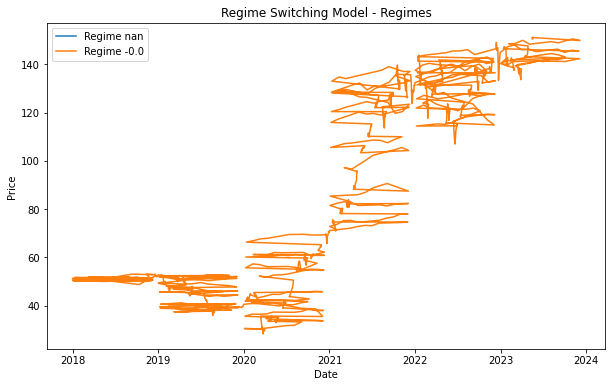

In [12]:
# Plot the regimes

fig, ax = plt.subplots(figsize=(10, 6))

for regime in funds['regime'].unique():
    
    regime_data = funds[funds['regime'] == regime]
    
    ax.plot(regime_data.index, regime_data['Price'], label=f"Regime {regime}")

ax.set_xlabel('Date')

ax.set_ylabel('Price')

ax.set_title('Regime Switching Model - Regimes')

ax.legend()

plt.show()

## Interpretation :

### The regime, labeled as -0.0, shows the estimated mean and volatility values. The mean value represents the average return of the time series data in this regime, which is approximately -0.000732 (negative value indicates a decrease in price). The volatility value, approximately 0.012977, represents the standard deviation or variability of the returns within this regime.

## 4) Expected Shortfall

### Expected Shortfall (ES), also known as Conditional Value-at-Risk (CVaR), is a risk measure that quantifies the expected loss beyond a specified confidence level. It provides a measure of the potential downside risk associated with an investment or portfolio.

In [13]:
# Define the confidence level (e.g., 95%)

confidence_level = 0.95

# Sort the daily returns in ascending order

sorted_returns = returns.sort_values()

# Determine the cutoff point index based on the confidence level

cutoff_index = int(confidence_level * len(sorted_returns))

# Calculate the expected shortfall (average of returns below the cutoff point)

expected_shortfall = sorted_returns[:cutoff_index].mean()

# Print the expected shortfall

print(f"Expected Shortfall at {confidence_level*100:.2f}% confidence level: {expected_shortfall:.4f}")

Expected Shortfall at 95.00% confidence level: -0.0026


## Interpretation : 

### Since the Expected Shortfall is negative (-0.0026), it implies that there is an anticipated downside risk in the mutual funds' returns. A negative Expected Shortfall indicates that, on average, the returns are expected to be below zero, which suggests a potential loss or decline in the investment.